### David Morales, 11/22/21, HW13
The purpose of the notebook is to create functions that will assist in the prediction of a one-week and two-week average streamflow along the Verde River.

## Grade
- **Readability: 3/3** Great job commenting I really like how you interspersed markdown cells to provide a narrative for your work it was all very easy to follow. 
- **Style: 3/3**  Looks good. 
- **Code: 2/3** Great use of functions! I especailly like all your plotting fucntions.  If you want some help figuring out how to import from a separate file let me know. Minus one point for not getting to add new functionality this week. Also, I was able to run most of your script but the paths for the map had some issues.  I'm glad you enjoyed using jupyter notebooks though!

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
from shapely.geometry import Point

#### Functions
The functions are added here because there were issues referencing them from another file.

In [2]:
# Create function for finding historical mean flows of desired timeframe
def historical_flow(data, start_year, start_month, start_day, end_day,
                    end_month=None):
    """Find yearly mean flow of chosen timeframe since chosen year.

    The timeframe will not cross years, it will only calculate dates within
    the same year. An upcoming edit that utilizes datetime will address this.

    This function uses a conditional to apply row extraction workflow depending
    on whether the timeframe extends across months. It then calculates their
    mean flow value for the week and adds it to a dataframe along with the
    values' corresponding year.

    Parameters
    ----------
    data : df
        dataframe from which to pull data
    start_year : int
        Year from which to begin timeframe
    start_month : int
        First month of flow in which the timeframe occurs
    start_day : int
        First day of the desired timeframe
    end_day : int
        Last day of the desired timeframe
    end_month : int (optional)
        Month in which the timeframe ends if it crosses month boundaries

    Returns
    ----------
    tf_avg_df : pandas dataframe
        Mean flow of timeframe and its year for every year since 1989
    """
    # generate lists that will receive looped year and flow values
    timeframe_avg_arr = []
    year_arr = []

    # calc number of iterations using start year
    df_year_range = data.groupby(['year']).describe()
    year_range = len(df_year_range.loc[start_year:])

    for year in range(year_range):

        # define year value that will be used in for_loop
        loop_year = start_year + year

        # capture date range if week overlaps month boundaries or not
        if end_month is None:
            month1 = data[(data['year'] == loop_year) &
                          (data['month'] == start_month) &
                          (data['day'] >= start_day) &
                          (data['day'] <= end_day)]
            # calc mean flow & add value to week_avg array
            tf_avg_value = np.round(np.mean(month1.flow), 2)

        else:
            month1 = data[(data['year'] == loop_year) &
                          (data['month'] == start_month) &
                          (data['day'] >= start_day)]
            month2 = data[(data['year'] == loop_year) &
                          (data['month'] == end_month) &
                          (data['day'] <= end_day)]
            # append dfs, calc mean flow & add to week_avg array
            tf_avg_value = np.round(np.mean(month1.append(month2).flow), 2)

        # add year and avg flow values to respective lists
        year_arr.append(loop_year)
        timeframe_avg_arr.append(tf_avg_value)

    # transfer lists into respective dataframes
    df1 = pd.DataFrame(year_arr)
    df2 = pd.DataFrame(timeframe_avg_arr)

    # concatenate dataframes into one and add col names
    tf_avg_df = pd.concat([df1, df2], axis=1)
    tf_avg_df.columns = ['year', 'flow']

    return tf_avg_df


# Function to calc change of flow (dQ)
def add_dQ_df(Qavg_df):
    """Calculate the change in mean flow of chosen timeframe from
    historical_mean() function and add it to dataframe.

    **The dataframe must have 0-based index,
      col1 = 'year', and col2 = 'flow'.**

    Parameters
    ----------
    Qavg_df : pandas dataframe
        Object assigned the output of historical_mean() function, or any df
        that fits the above bolded criteria.

    Returns
    ----------
    Qavg_df : pandas dataframe
        The output of this function is the same dataframe input with an added
        column, 'dQ', containing the change in mean flow between years.
    """
    # generate lists that will receive flow difference and looped year values
    flow_diff_arr = []
    flow_diff_year_arr = []

    # calc number of iterations by using df length
    years = len(Qavg_df)

    for i in range(years-1):

        # set year values
        new_year = i+1
        old_year = i

        # find difference in avg flow values (dQ)
        flow_diff = Qavg_df.iloc[new_year, 1] - Qavg_df.iloc[old_year, 1]

        # add year and flow diff values to respective lists
        flow_diff_year_arr.append(Qavg_df.iloc[new_year, 0])
        flow_diff_arr.append(flow_diff)

    # transfer lists to respective dataframes
    df1 = pd.DataFrame(flow_diff_year_arr)
    df2 = pd.DataFrame(flow_diff_arr)

    # concatendate dataframes into one and add col names
    dQ_df = pd.concat([df1, df2], axis=1)
    dQ_df.columns = ['year', 'dQ']

    dQ_df.loc[-1] = [1989, 0]
    dQ_df.index = dQ_df.index + 1
    dQ_df = dQ_df.sort_index()
    Qavg_df.insert(2, 'dQ', dQ_df.dQ)

    return Qavg_df


# Function to quickly generate plots (req'd 3)
def flow_analysis(Qavg_df):
    """Generate three plots to better undestand avg flow of timeframe.

    Parameters
    ----------
    Qavg_df : pandas dataframe
        Same output from add_dQ_df() function.

    Return
    ----------
    Plot1 : line chart
        Line chart of avg flow by year to identify long term patterns
        and changes.
    Plot2 : scatterplot
        Scatterplot of change in flow vs years.
    Plot3 : scatterplot
        Scatterplot of avg flow vs the change across years. Plot uses
        colorbar to aid understanding of changing patterns.
    """
    # line graph of the yearly mean flow for the dataframe's timeframe
    fig, ax = plt.subplots()

    ax.plot(Qavg_df['year'], Qavg_df['flow'], '-p', label='timeframe avg flow')
    ax.set(title="Mean Flow by Year", xlabel="Year",
           ylabel="Yearly Flow Rate Change [cfs/year]")
    ax.legend()

    # scatterplot of the change in mean flow across years
    fig, ax = plt.subplots()

    ax.plot(Qavg_df['year'], Qavg_df['dQ'], 'c')
    ax.set(title="Change in Mean Flow by Year", xlabel="Year",
           ylabel="\u0394Flow")
    ax.scatter(Qavg_df['year'], Qavg_df['dQ'],
               c=Qavg_df['year'], cmap=plt.cm.get_cmap('plasma'))

    # Scatterplot of avg flow vs rate of change
    fig, ax = plt.subplots()
    plt.scatter(Qavg_df.flow, Qavg_df.dQ,
                c=Qavg_df['year'], cmap='plasma')
    plt.colorbar()
    ax.set(xlabel="Mean Flow", ylabel="\u0394Flow",
           title="Mean Flow by Change in Mean Flow")

    return


# Function for quickly printing out stats for week dataframes
def week_stat(df1, df2=None):
    """Evaluate stats of up to two dataframes. Namely, the two
    one week forecasts.

    Parameters
    ----------
    df1 : pandas dataframe
        This argument is mandatory and provides the dataframe meant to
        be analyzed statistically.
    df2 : pandas detaframe (optional)
        This argument is meant to include a second forecast if the
        user so choses to include one; in the context of this assignment,
        the second dataframe is the two-week forecast.

    Return
    ----------
    Printed stats of the year, flow, and dQ column.
    """
    # Print out the Week 1 statistical information using a .describe() method.
    print("First DataFrame stats:\n", np.round(df1.describe(), 2),
          "\nFirst Dataframe median:", df1.flow.median())
    if df2 is not None:
        # Print out the Week 2 stats using a .describe() method.
        print("\nSecond DataFrame stats:\n", np.round(df2.describe(), 2),
              "\nSecond DataFrame median:", df2.flow.median())

    return

#### Data
The data used for the forecast include historical streamflow values from a stream gauge along the Verde River.

In [3]:
# Pulling data from streamflow13.txt
filename = 'streamflow_week13.txt'
filepath = os.path.join('data', filename)

filepath = '../data/streamflow_week13.txt'

# Read the data into a pandas df
data = pd.read_table(filepath, sep='\t', skiprows=30,
                     names=['agency_cd', 'site_no',
                            'datetime', 'flow', 'code'])

# Expand the dates to year, month, day
data[["year", "month", "day"]] = data["datetime"].str.split("-", expand=True)
data['year'] = data['year'].astype(int)
data['month'] = data['month'].astype(int)
data['day'] = data['day'].astype(int)

#### Generating forecasts
These functions have worked well by evaluating historical flows and finding their averages. The most insightful aspect of this code is the graphs that they create (see below).

In [4]:
wk1 = add_dQ_df(historical_flow(data,2010, 11, 21, 27))
wk2 = add_dQ_df(historical_flow(data,2010, 11, 28, 4, 12))

# Print WEEKLY FORECASTS and stats for week 1 and week 2
week_stat(wk1, wk2)
print("\n------------------------\n\nWeek 1 forecast:",
      np.round(wk1.flow.mean(), 2), "\nWeek 2 forecast:",
      np.round(wk2.flow.mean(), 2))

First DataFrame stats:
           year    flow     dQ
count    12.00   11.00  11.00
mean   2015.50  182.69  -3.40
std       3.61   31.29  51.16
min    2010.00  147.43 -81.72
25%    2012.75  163.21 -33.58
50%    2015.50  173.57  -2.58
75%    2018.25  196.58  17.86
max    2021.00  255.29  98.58 
First Dataframe median: 173.57

Second DataFrame stats:
           year    flow      dQ
count    12.00   11.00   11.00
mean   2015.50  212.83   -1.65
std       3.61  109.88  169.52
min    2010.00  158.00 -381.29
25%    2012.75  169.93  -22.28
50%    2015.50  176.14    0.00
75%    2018.25  189.50    9.08
max    2021.00  539.29  367.43 
Second DataFrame median: 176.14

------------------------

Week 1 forecast: 182.69 
Week 2 forecast: 212.83


#### Generating plots
The forecast dataframes are now plugged into the flow_analysis function. 
- The first three graphs relate to the one-week forecast
- The last three graphs relate to the two-week forecast

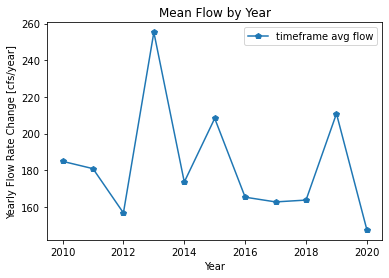

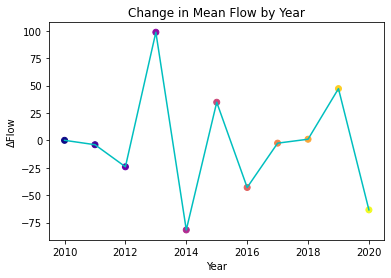

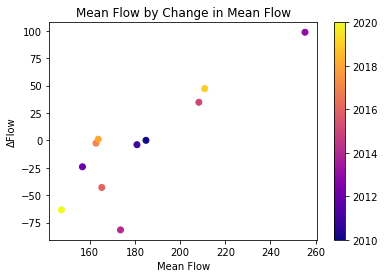

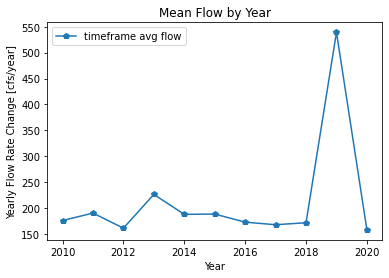

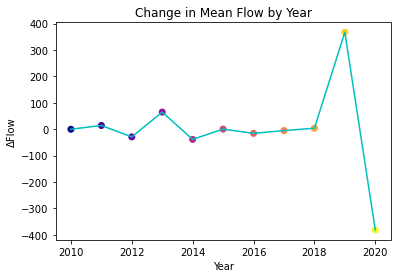

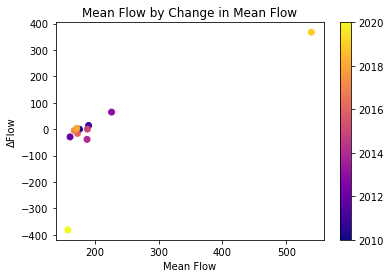

In [5]:
# Explore week 1 and 2 flows graphically
flow_analysis(wk1)
flow_analysis(wk2)

#### Generating a map
The map used in this analysis include:
- Arizona state boundary
- the Salt and Verde Rivers
- dams found within the state
- a burn area from the Backbone Fire
- the location of the stream gauge from which the stream analysis data originate

In [6]:
# Prepare data for AZ State Boundary using Geodatabase:
# https://azgeo-open-data-agic.hub.arcgis.com/datasets/azgeo::arizona-state-boundary/about
file = os.path.join('..', 'data',
                    'Arizona_State_Boundary-fgdb',
                    'd09edca433824603876f0a303adb5404.gdb')
fiona.listlayers(file)
azboundary = gpd.read_file(file, layer='azboundary')

# Prepare data for 2021 AZ wildfires using shapefile:
# https://azgeo-open-data-agic.hub.arcgis.com/datasets/nifc::wfigs-2021-wildland-fire-perimeters-to-date/explore?location=33.938905%2C-111.146632%2C7.92

file = os.path.join('../', 'data',
                    'WFIGS_-_2021_Wildland_Fire_Perimeters_to_Date',
                    'FH_Perimeter.shp')
fires = gpd.read_file(file)

# Select the polygon for Backbone Fire burn area:
fires_backbone = fires[fires['OBJECTID'] == 11575]

# Prepare data for AZ dams using shapefile:
# https://geodata-asu.hub.arcgis.com/datasets/asu::national-inventory-of-dams-arizona-2018/about

file = os.path.join('../', 'data',
                    'National_Inventory_of_Dams_-_Arizona_(2018)',
                    'National_Inventory_of_Dams_-_Arizona_(2018).shp')
dams = gpd.read_file(file)

# Prepare data for Ephemeral and Perennial Streams in AZ using shapefile:
# https://azgeo-open-data-agic.hub.arcgis.com/datasets/azgeo::streams-ephemeral-and-perennial/about
file = os.path.join('..', 'data',
                    'Streams___Ephemeral_and_Perennial-shp',
                    'Streams___Ephemeral_and_Perennial.shp')
streams = gpd.read_file(file)

# Pulling for large river:
verde_river = streams[streams['NAME'] == 'Verde River']
salt_river = streams[streams['NAME'] == 'Salt River']

# Prepare data for HUC1506 watershed using geodatabase:
# https://www.sciencebase.gov/catalog/item/5d30c292e4b01d82ce84aa34

file = os.path.join('..', 'data',
                    'NHDPLUS_H_1506_HU4_GDB',
                    'NHDPLUS_H_1506_HU4_GDB.gdb')
fiona.listlayers(file)
HUC8_1506 = gpd.read_file(file, layer="WBDHU8")

# Prepare data for HUC1408 watershed using shapefile:
# https://azgeo-open-data-agic.hub.arcgis.com/datasets/azgeo::us-4-digit-hus-subregion/explore?filters=eyJzdGF0ZXMiOlsiQVoiLCJBWixDQSxNWCxOViIsIkFaLENPLE5NLFVUIiwiQVosTVgiLCJBWixNWCxOTSIsIkFaLE5NIiwiQVosTlYsVVQiLCJBWixVVCJdfQ%3D%3D
file = os.path.join('..', 'data',
                    'US_4-digit_HUs_AZ',
                    'US_4-digit_HUs_AZ.shp')
HUC4 = gpd.read_file(file)
HUC4_AZ = HUC4.drop(index=4)
fires.total_bounds
dams.total_bounds

# %%
# Reproject vector objects to NAD83 | Lat(N)/Lon(E) | degrees:
HUC4_AZ_nad83 = HUC4_AZ.to_crs(HUC8_1506.crs)
azboundary_nad83 = azboundary.to_crs(HUC8_1506.crs)
fires_backbone_nad83 = fires_backbone.to_crs(HUC8_1506.crs)
dams_nad83 = dams.to_crs(HUC8_1506.crs)
verde_river_nad83 = verde_river.to_crs(HUC8_1506.crs)
salt_river_nad83 = salt_river.to_crs(HUC8_1506.crs)

# %%
dams_nad83_clip = gpd.clip(dams_nad83, HUC8_1506)
HUC4_AZ_nad83_clip = gpd.clip(HUC4_AZ_nad83, azboundary_nad83)

# %%
# Stream gauge:  34.44833333, -111.7891667
point_list = np.array([[-111.7891667, 34.44833333]])
# make these into spatial features
point_geom = [Point(xy) for xy in point_list]
point_geom

# map a dataframe of these points
point_df = gpd.GeoDataFrame(point_geom, columns=['geometry'],
                            crs=HUC8_1506.crs)

# %%
# plot these on the first dataset

fig, ax = plt.subplots(figsize=(15, 15))

azboundary_nad83.boundary.plot(ax=ax,
                               color=None,
                               edgecolor='black',
                               linewidth=1,
                               label='AZ State Boundary')
verde_river_nad83.plot(ax=ax,
                       linewidth=.6,
                       color='dodgerblue',
                       label='Verde River')
salt_river_nad83.plot(ax=ax,
                      linewidth=.5,
                      color='blue',
                      label='Salt River')
HUC8_1506.plot(ax=ax,
               color='lightskyblue',
               alpha=.8,
               legend=True)
HUC4_AZ_nad83_clip.plot(ax=ax,
                        color='lightskyblue',
                        edgecolor='turquoise',
                        alpha=.3)
point_df.plot(ax=ax,
              color='fuchsia',
              marker='o',
              markersize=60,
              label='Stream Gauge')
dams_nad83_clip.plot(ax=ax,
                     marker='x',
                     color='brown',
                     label='Active Dams')
fires_backbone_nad83.plot(ax=ax,
                          color='gold')

ax.set_title("HU4 - 1506 w/ Surrounding HU4 Boundaries")
ax.legend()
plt.show()

DriverError: ../data/Arizona_State_Boundary-fgdb/d09edca433824603876f0a303adb5404.gdb: No such file or directory

#### Discussion
My performance in the forecast competition has been lackluster though not for lack of effort on my behalf. It's surprising to learn that those who have performed best in the competition self-report to rely largely on guesstimating. That being said, I appreciate the functions I have created, particularly the plots because I think they are quite capable in providing insight to how flow is changing in the river through time. 

The two-week forecast (seen below) for this assignment was really striking in seeing how little flow has changed for the week Nov. 28-Dec. 4 up until the last two years. 

![picture 1](../images/e314441cdbc441ecb49ee201c1860e0a111a82e37364c596a86558ef04f87820.png) 

Furthermore, in analyzing the statistical data for the two-week forecast, the sample size of 12 years suggests that the forecast (based on the flow mean) is highly susceptible to sampling fluctuations--such as those we see in the last two years. Considering this, I will actually need to change my forecast code.


#### Updated print statement for two-week forecast
I will leave the one-week forecast alone because the variations in sampling fluctuations seen in the results are not substantial enough to warrant deferral to the median.

In [7]:
print("Updated two-week forecast:", wk2.flow.median(), "cfs")

Updated two-week forecast: 176.14 cfs


#### Added analysis
Unfortunately, I was not able to incorporate a new analytical feature into my code this week. It was not for lack of trying and scouring the library. A combination of hyper-focusing on advanced statistical analysis (beyond linear regression models, which we had already learned) and procrastination resulted in this omission. I'm disappointed but the experience of using Jupyter notebooks is wildly exciting.